In [45]:
!pip3 install numpy pandas opencv-python matplotlib tensorflow glob2

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [46]:
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
incept_model=ResNet50(include_top=True)


In [47]:
images_path ="/Users/suryashukla/Downloads/archive/Flickr8k_Dataset/Flicker8k_Dataset"
images=glob(images_path+'/*.jpg')
len(images)

8091

In [48]:
images[:5]


['/Users/suryashukla/Downloads/archive/Flickr8k_Dataset/Flicker8k_Dataset/2387197355_237f6f41ee.jpg',
 '/Users/suryashukla/Downloads/archive/Flickr8k_Dataset/Flicker8k_Dataset/2609847254_0ec40c1cce.jpg',
 '/Users/suryashukla/Downloads/archive/Flickr8k_Dataset/Flicker8k_Dataset/2046222127_a6f300e202.jpg',
 '/Users/suryashukla/Downloads/archive/Flickr8k_Dataset/Flicker8k_Dataset/2853743795_e90ebc669d.jpg',
 '/Users/suryashukla/Downloads/archive/Flickr8k_Dataset/Flicker8k_Dataset/2696951725_e0ae54f6da.jpg']

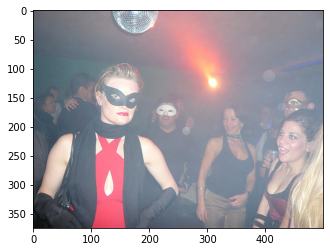

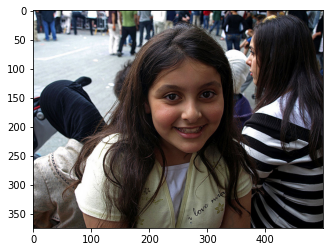

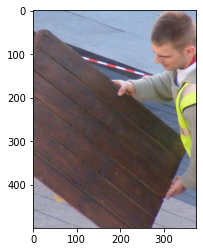

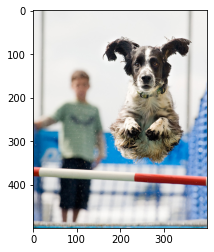

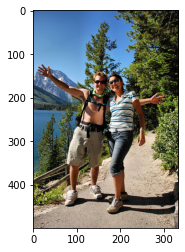

In [49]:
for i in range(5):
  plt.figure()
  img=cv2.imread(images[i])
  img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)

In [50]:
incept_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [51]:
len(images)

8091

In [52]:
last=incept_model.layers[-2].output
modele =Model(inputs=incept_model.input,outputs=last)
modele.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [53]:
images_features={}
count=0
num_of_images_in_dataset=len(images)
for i in images:
  img=cv2.imread(i)
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img=cv2.resize(img,(224,224))

  img=img.reshape(1,224,224,3)
  pred=modele.predict(img).reshape(2048,)
  img_name=i.split('/')[-1]
  images_features[img_name]=pred
  count+=1
  if count>num_of_images_in_dataset:  
    break
  elif count % 50 ==0:
    print(count)

50


KeyboardInterrupt: 

In [ ]:
caption_path="/Users/suryashukla/Downloads/archive/Flickr8k_text/Flickr8k.token.txt"


In [ ]:
captions=open(caption_path,'rb').read().decode('utf-8').split('\n')


In [ ]:
captions


In [ ]:
captions_dict={}
for i in captions:
  try:
    img_name = i.split('\t')[0][:-2]
    caption = i.split('\t')[1]
    if img_name in images_features:
      if img_name not in captions_dict:
        captions_dict[img_name]=[caption]
      else:
        captions_dict[img_name].append(caption)
  except:
    pass


In [ ]:
captions_dict

In [ ]:
len(captions_dict)

In [ ]:
def preprocessed(txt):
  modified =txt.lower()
  modified ='startofseq '+modified+' endofseq'
  return modified

In [ ]:
for k,v in captions_dict.items():
  for vv in v:
    captions_dict[k][v.index(vv)]=preprocessed(vv)

In [ ]:
captions_dict

In [ ]:
count_words={}
count=1
for k, vv in captions_dict.items():
  for v in vv:
    for word in v.split():
      if word not in count_words:
        count_words[word]=count
        count+=1

In [ ]:
len(count_words)

In [ ]:
count_words

In [ ]:
for k,vv in captions_dict.items():
  for v in vv:
    encoded=[]
    for word in v.split():
      encoded.append(count_words[word])
    
    captions_dict[k][vv.index(v)]=encoded

In [ ]:
captions_dict

In [ ]:
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences


In [ ]:
Max_len=0
for k, vv in captions_dict.items():
  for v in vv:
    if(len(v)>Max_len):
      Max_len=len(v)
      print(v)

In [ ]:
Max_len

In [ ]:
Vocab_size=len(count_words)

def generator(photo, caption):
  x=[]
  y_in=[]
  y_out=[]

  for k,vv in caption.items():
    for v in vv:
      for i in range(1,len(v)):
        x.append(photo[k])

        in_seq=[v[:i]]
        out_seq=v[i]

        in_seq = pad_sequences(in_seq,maxlen=Max_len,padding='post',truncating='post')[0]
        out_seq = to_categorical([out_seq],num_classes=Vocab_size+1)[0]

        y_in.append(in_seq)
        y_out.append(out_seq)
  
  return x, y_in, y_out


In [ ]:
X, y_in, y_out = generator(images_features, captions_dict)

In [ ]:
len(X), len(y_in),len(y_out)

In [ ]:
X[:5] , y_in[:5], y_out[:5]

In [ ]:
X=np.array(X)
y_in=np.array(y_in,dtype='float64')
y_out =np.array(y_out, dtype='float64')

In [ ]:
X.shape, y_in.shape, y_out.shape

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, Input, Convolution2D, Dropout, LSTM, TimeDistributed,Embedding, Bidirectional, Activation, RepeatVector, Concatenate
from tensorflow.keras.models import Sequential,Model








In [ ]:
embedding_size = 128
max_len = Max_len
vocab_size = len(count_words)+1

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
model.fit([X,y_in],y_out,batch_size=512,epochs=5)

In [ ]:
inv_dict = {v:k for k,v in count_words.items()}

In [87]:
def getImage(x):
    
    test_img_path = x

    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    test_img = cv2.resize(test_img, (224,224))

    test_img = np.reshape(test_img, (1,224,224,3))
    
    return test_img
  

In [101]:
test_img_indx=4000

In [102]:
test_feature=modele.predict(getImage('/Users/suryashukla/Desktop/manc3.png')).reshape(1,2048)

In [103]:
test_feature

array([[1.2539272 , 1.1881995 , 0.07035013, ..., 0.03591637, 0.05407342,
        0.07218735]], dtype=float32)

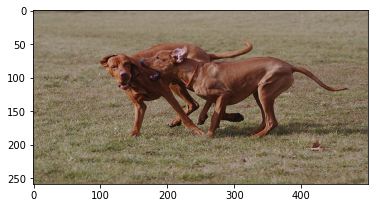

In [104]:
test_img_path = images[test_img_indx]
test_img=cv2.imread(test_img_path)
test_img=cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(test_img)

In [105]:
text_inp = ['startofseq']

count = 0
caption = ''
while count < 40:
    count += 1

    encoded = []
    for i in text_inp:
        encoded.append(count_words[i])

    encoded = [encoded]

    encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=Max_len)


    prediction = np.argmax(model.predict([test_feature, encoded]))

    sampled_word = inv_dict[prediction]
    if sampled_word == 'endofseq':
        break

    caption = caption + ' ' + sampled_word
        
    

    text_inp.append(sampled_word)

In [106]:
caption

' a woman in a black shirt is holding a picture .'